# Analise Exploratoria

In [ ]:
# %%capture

# !apt-get update
# !apt-get install openjdk-11-jdk -y
# %pip install ipykernel

# %pip install 'sagemaker[feature-processor]' --force-reinstall

In [14]:
# %pip install -q sagemaker[local]
# %pip install sagemaker_datawrangler
# %pip install sagemaker-core
# pip install sagemaker-experiments
# pip install sagemaker-studio-image-build

In [17]:
# %pip install -r ./requirements.txt -q

In [2]:
# %pip install seaborn
# %pip install s3fs

In [3]:
import os
import re
import sys
import math
import json
import boto3
import logging
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image, display
from IPython.display import FileLink, FileLinks
from time import gmtime, strftime

from sagemaker.s3 import S3Uploader, S3Downloader, s3_path_join
from sagemaker import Session
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.spark.processing import PySparkProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [9]:
logger = logging.getLogger("SagemakerStudio")
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [10]:
print(pd.__version__)
print(sagemaker.__version__)

2.1.4
2.214.3


In [11]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

In [14]:
account_id = boto3.client("sts").get_caller_identity().get("Account")
boto_session = boto3.Session()
region_name = boto_session.region_name
client_sagemaker = boto_session.client("sagemaker")
client_s3 = boto_session.client("s3")
sagemaker_session = sagemaker.Session()
sagemaker_role = sagemaker.get_execution_role()
bucket_name = sagemaker_session.default_bucket()

s3_prefix = "workshop_v2"
s3_data_raw_prefix = "data/raw"
dataset_raw = "bank-additional-full.csv"
local_prefix = "./data/raw"

input_s3_url = f"s3://{bucket_name}/{s3_prefix}/{s3_data_raw_prefix}/{dataset_raw}"

initialized = True

In [15]:
print(f"sagemaker_role:     {sagemaker_role}")
print(f"region_name:        {region_name}")
print(f"bucket_name:        {bucket_name}")
print(f"s3_prefix:          {s3_prefix}")
print(f"s3_data_raw_prefix: {s3_data_raw_prefix}")
print(f"dataset_raw:        {dataset_raw}")
print(f"local_prefix:       {local_prefix}")
print(f"input_s3_url:       {input_s3_url}")
print(f"initialized:        {initialized}")

sagemaker_role:     arn:aws:iam::891377318910:role/service-role/SageMaker-DataScientistRole
region_name:        us-east-1
bucket_name:        sagemaker-us-east-1-891377318910
s3_prefix:          workshop_v2
s3_data_raw_prefix: data/raw
dataset_raw:        bank-additional-full.csv
local_prefix:       ./data/raw
input_s3_url:       s3://sagemaker-us-east-1-891377318910/workshop_v2/data/raw/bank-additional-full.csv
initialized:        True


### Store variables between notebooks

In [16]:
%store bucket_name
%store region_name
%store sagemaker_role
%store s3_prefix
%store s3_data_raw_prefix
%store dataset_raw
%store local_prefix
%store input_s3_url
%store initialized

Stored 'bucket_name' (str)
Stored 'region_name' (str)
Stored 'sagemaker_role' (str)
Stored 's3_prefix' (str)
Stored 's3_data_raw_prefix' (str)
Stored 'dataset_raw' (str)
Stored 'local_prefix' (str)
Stored 'input_s3_url' (str)
Stored 'initialized' (bool)


### Download raw dataset

In [ ]:
# key_prefix = f"{s3_prefix}/{s3_data_prefix}/{dataset_raw}"
# client_s3.download_file(Bucket=bucket_name, Key=key_prefix, Filename=local_prefix)
# client_s3.upload_file(data_filename, output_bucket, output_key)

# train_data_s3_path = sagemaker_session.upload_data(
#     path=train_file,
#     bucket=bucket_name,
#     key_prefix=prefix + "/train"
# )

# RAW_CAR_SALES_S3_URI = S3Uploader.upload(
#     CAR_SALES_DATA_DIR,
#     f"s3://{s3_bucket}/{s3_data_prefix}"
# )

# car_data_s3_uri = s3_path_join(
#     "s3://", sagemaker_session.default_bucket(), "transformation_code", "car-data-ingestion.py"
# )

# S3Uploader.upload(local_path="car-data-ingestion.py", desired_s3_uri=car_data_s3_uri)

# s3_uri = f"s3://sagemaker-example-files-prod-{region}/datasets/tabular/uci_bank_marketing/bank-additional-full.csv"
# S3Downloader.download(
#     s3_uri, local_path="./bank-additional/",
#     sagemaker_session=sagemaker.Session()
# )

In [28]:
sagemaker_session.download_data(
    path=local_prefix,
    bucket=bucket_name,
    key_prefix=f"{s3_prefix}/{s3_data_raw_prefix}/{dataset_raw}"
)

['./data/raw/bank-additional-full.csv']

### Load dataset

In [29]:
local_path_dataset = f"{local_prefix}/{dataset_raw}"

df_raw = pd.read_csv(local_path_dataset, sep=";")

In [32]:
df_raw.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [33]:
col_target = "y"

%store col_target

Stored 'col_target' (str)


# Analise Exploratoria

In [34]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numerical_columns = ['age', 'duration', 'campaign', 'pdays', 'previous']

In [35]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [36]:
df_raw.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [37]:
df_raw.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

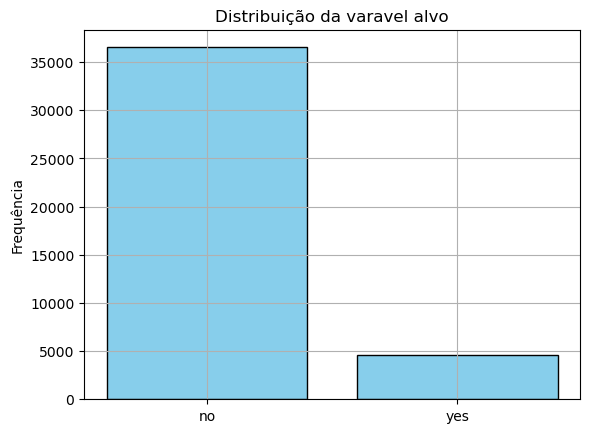

In [38]:
values_count = df_raw[col_target].value_counts()
plt.bar(values_count.index, values_count.values, color='skyblue', edgecolor='black')
plt.ylabel('Frequência')
plt.title('Distribuição da varavel alvo')
plt.grid(True)
plt.show()

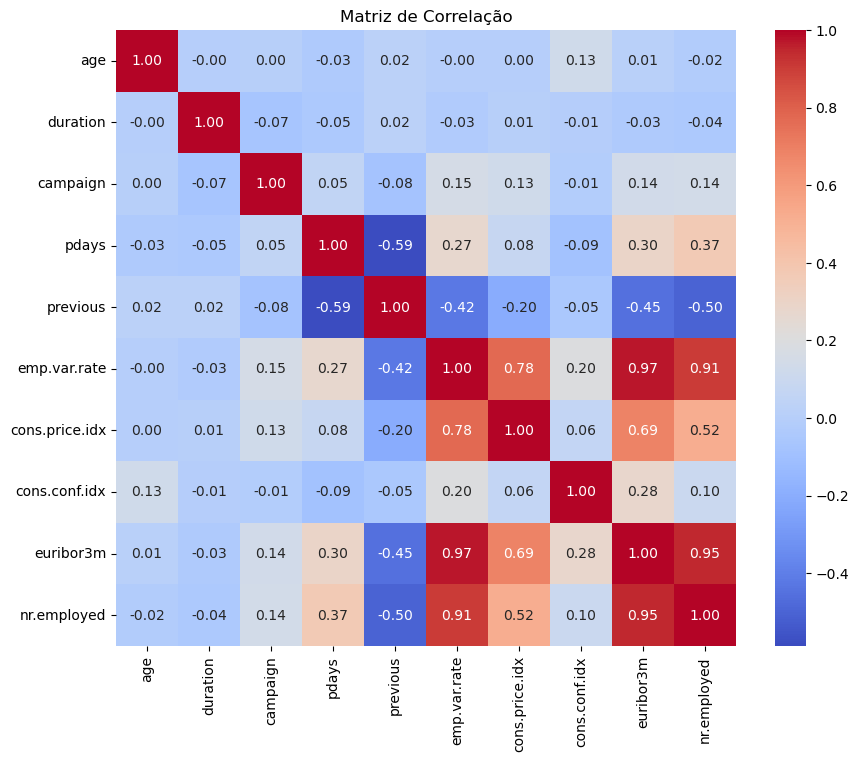

In [39]:
df_numeric = df_raw.select_dtypes(include=['int64', 'float64'])
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

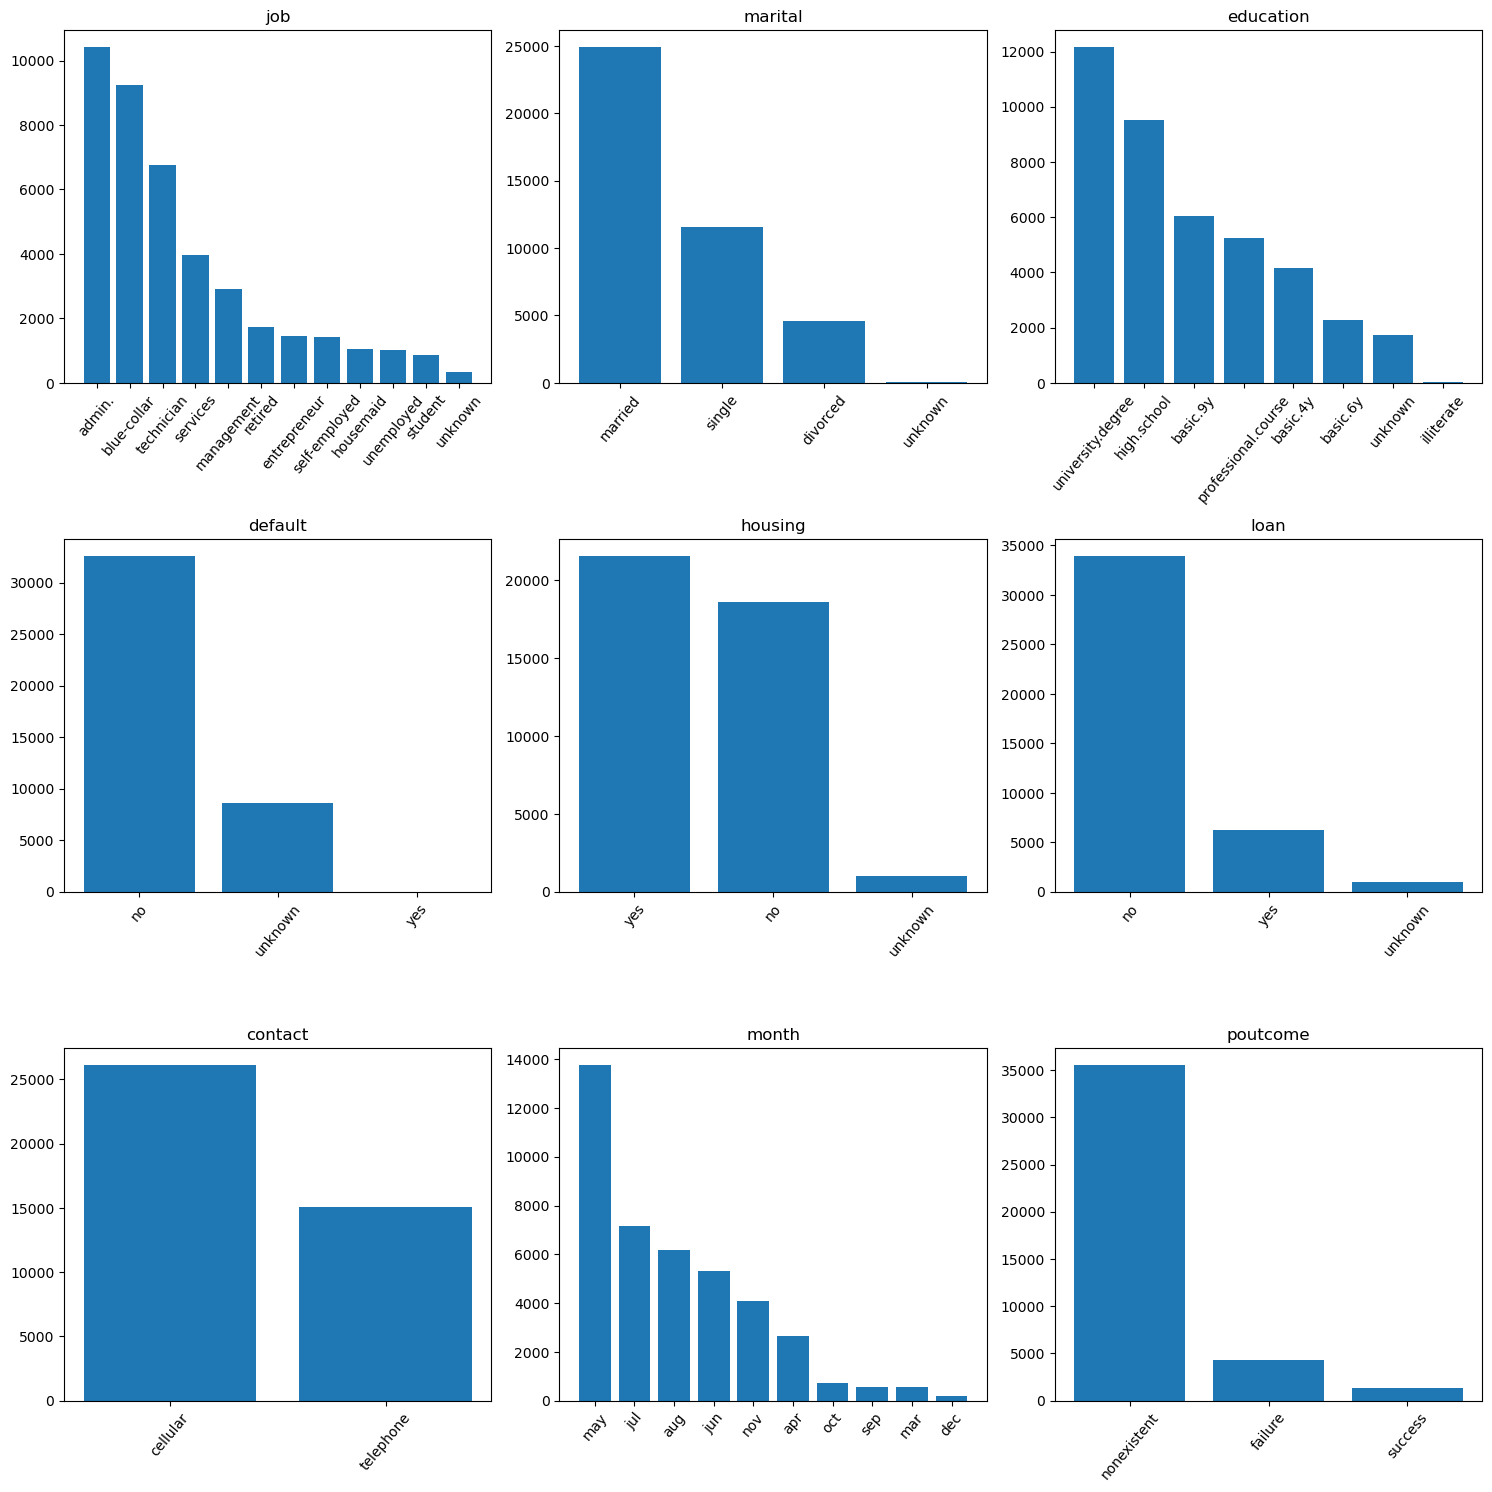

In [40]:
fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(15, 15), tight_layout=True)

counter = 0

for cat_column in categorical_columns:
    value_counts = df_raw[cat_column].value_counts()

    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))

    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label=value_counts.index)
    axs[trace_x, trace_y].set_title(cat_column)

    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(50)
        tick.set_fontsize(10)

    counter += 1

fig.tight_layout(pad=1.0)
plt.show()

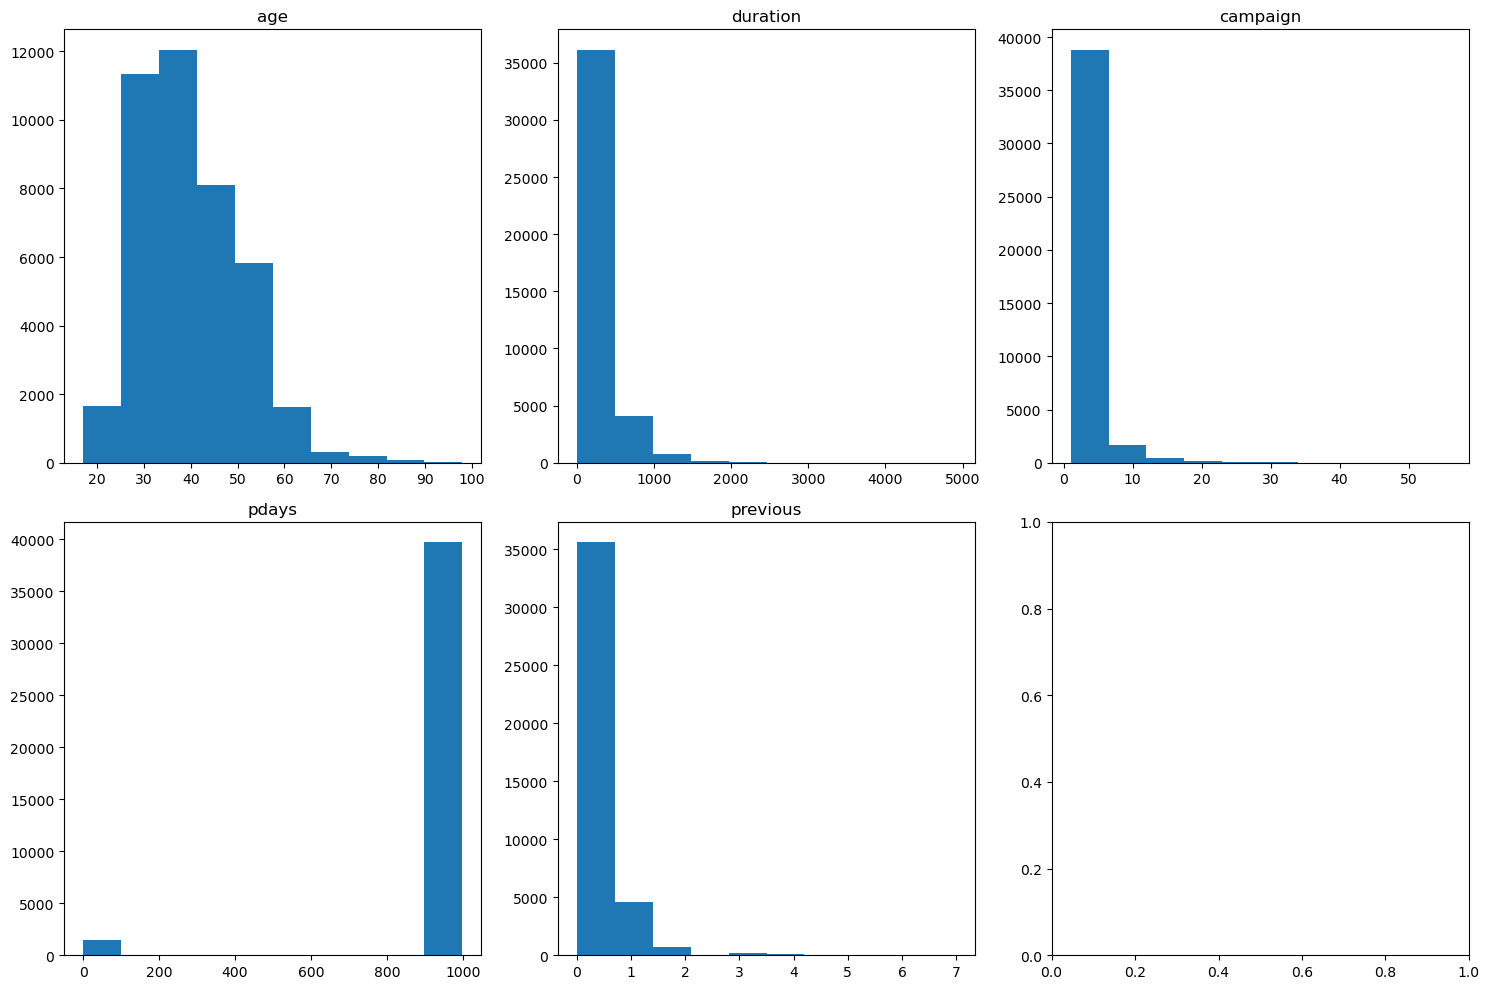

In [41]:
fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(15, 10), tight_layout=True)

counter = 0
for num_column in numerical_columns:
    trace_x = counter // 3
    trace_y = counter % 3

    axs[trace_x, trace_y].hist(df_raw[num_column])
    axs[trace_x, trace_y].set_title(num_column)

    counter += 1

plt.show()

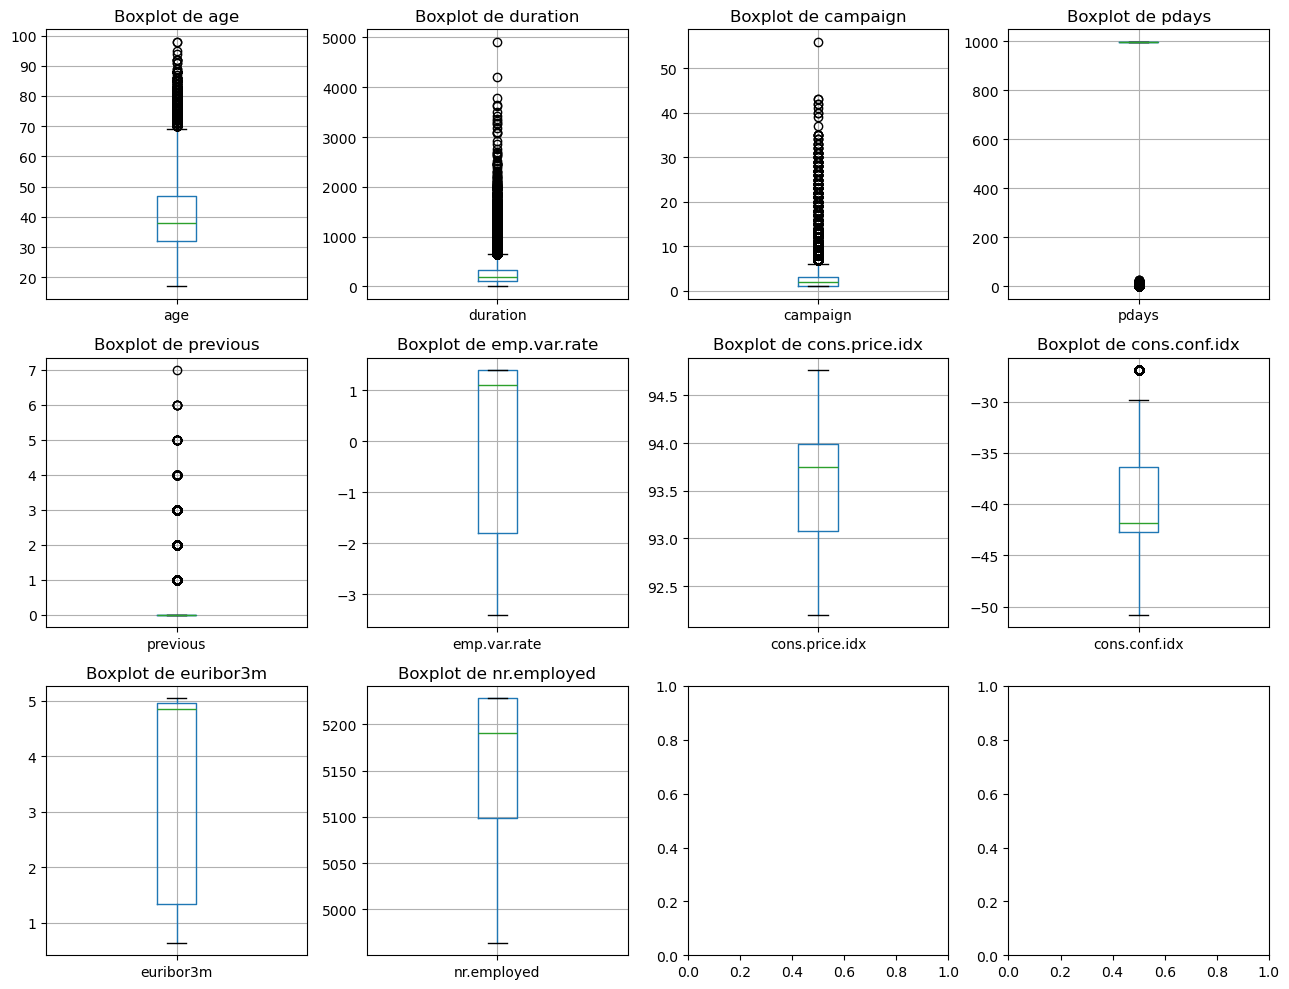

In [42]:
df_numeric = df_raw.select_dtypes(include=['int64', 'float64'])

num_cols = 4
num_rows = math.ceil((len(df_numeric.columns) - 1) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 10))
axes = axes.flatten()

for i, column in enumerate(df_numeric.columns):
    df_numeric.boxplot(column=[column], ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}')

for j in range(num_rows * num_cols, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

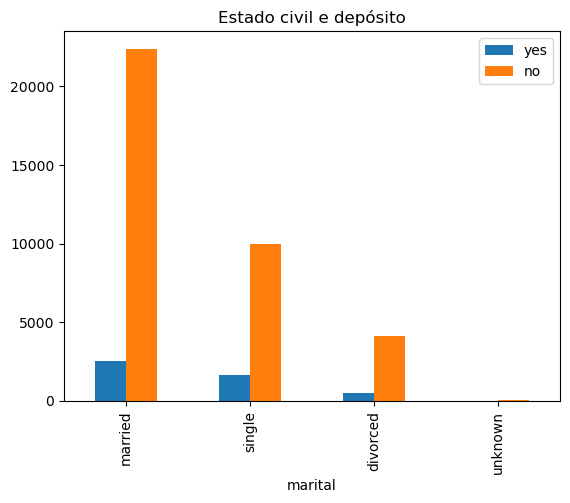

In [43]:
df_j = pd.DataFrame()

df_j['yes'] = df_raw[df_raw[col_target] == 'yes']['marital'].value_counts()
df_j['no'] = df_raw[df_raw[col_target] == 'no']['marital'].value_counts()

df_j.plot.bar(title="Estado civil e depósito")
plt.show()